# Statistical Tests Notebook

Initialize notebook

In [3]:
import numpy as np
import matplotlib.pyplot as plt


## Sample 1: BASTE Data

### Test 1: Duration (T90) distribution <br>
__T90 definition__ <br> 
The 90% duration of the burst in seconds. T90 measures the duration of the time interval during which 90% of the total observed counts have been detected. The start of the T90 interval is defined by the time at which 5% of the total counts have been detected, and the end of the T90 interval is defined by the time at which 95% of the total counts have been detected. <br>
_(definition from: https://heasarc.gsfc.nasa.gov/grbcat/notes.html)_ <br>


NB: For BATSE, all the T90s of the GRBs have been already evaluated by Cristiano. The file is uploaded on the repository for easier access. <br>
_(file path on Gravity: /astrodata/guidorzi/CGRO_BATSE/T90_full.dat, file path on the repository: lc_pulse_avalance/statistical_tests/cgro_batse/T90_full.dat)_


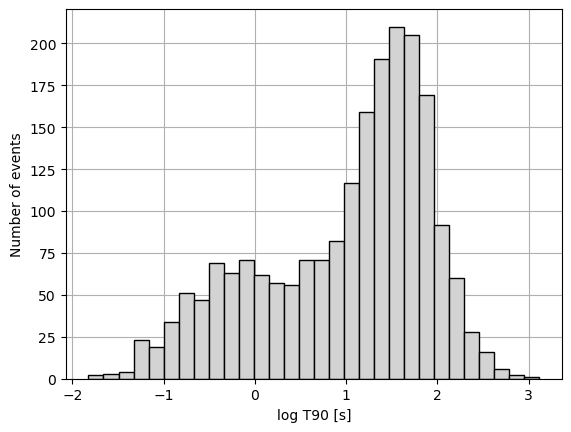

In [52]:
grb, t90, t90_error = np.loadtxt('cgro_batse/T90_full.dat', unpack = True)
log10_t90 = np.log10(t90)

fig = plt.figure()
ax = fig.add_subplot()
ax.set_axisbelow(True)
ax.grid(which = 'both')
ax.set_ylabel('Number of events')
ax.set_xlabel('log T90 [s]')

n, bins, patches = ax.hist(log10_t90, bins = 30, facecolor = 'lightgrey', edgecolor = 'black')


t90_avg = np.mean(t90)
t90_var = np.var(t90)


#### T90 Calculation function
A function to evaluate the T90 of a GRB given 1) times of the lightcurve bins and 2) counts per bin 

In [47]:
def evaluateT90(times, counts):
    cumulative_counts = np.round(np.cumsum(counts)/np.sum(counts)*100)
    t_5 = times[np.where(cumulative_counts == 5)[0][0]]
    t_95 = times[np.where(cumulative_counts == 95)[0][0]]
    return t_95-t_5

## Test 2: Average Peak-Aligned Profiles

Following the technique described in Mitranof et al., 1996 (https://ui.adsabs.harvard.edu/abs/1996MmSAI..67..417M/abstract) and working on the time interval from 0 to 150 s from the peak (as done in Stern+1996)

#### (WIP)

In [12]:
###########                  TEST ON A BUNCH OF GRBs             #################
#########TESTED on all the long GRBs in alltrig_long.list        ############
bin_time = 0.064 #[s] temporal bins for BATSE

file_path = 'E:/grb_to_test/CGRO_BATSE/'
#grb_list = ["00105_all_bs.out","00107_all_bs.out","00108_all_bs.out","00109_all_bs.out","00110_all_bs.out"]
grb_list = [grb_num.rstrip('\n') + '_all_bs.out' for grb_num in open(file_path + 'alltrig_long.list').readlines()] +  [grb_num.rstrip('\n') + '_all_bs.out' for grb_num in open(file_path + 'alltrig_short.list').readlines()]
test_times = np.arange(0,150,0.064) #Same time range as in Stern+1996
averaged_fluxes = np.zeros_like(test_times)
for grb in grb_list:
    times, counts, errs = np.loadtxt(file_path+grb, unpack=True)
    c_max = np.max(counts)
    i_t_max = np.where(counts == c_max)[0][0]
    t_max = times[i_t_max]
    counts_to_sum = counts[i_t_max:i_t_max + len(test_times)] / c_max
    if len(counts_to_sum) < len(test_times):
        counts_to_sum = np.concatenate([counts_to_sum, [0]*(len(test_times) - len(counts_to_sum))])
    averaged_fluxes += counts_to_sum

averaged_fluxes /= len(grb_list)
#Plot of <F/Fp> and <F/Fp>^3 in the next cell

Note: some negative values (close to zero) appearing for times^1/3 > 4.  

c:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
c:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


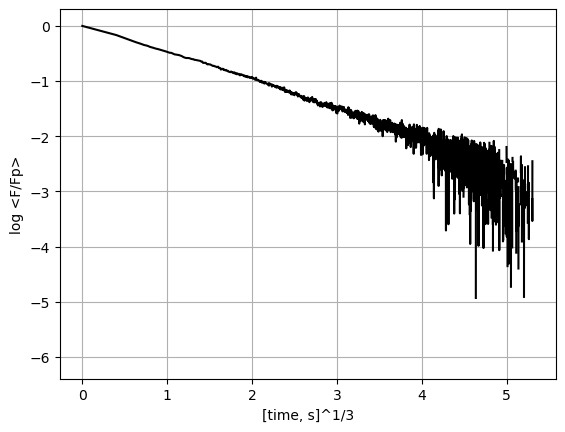

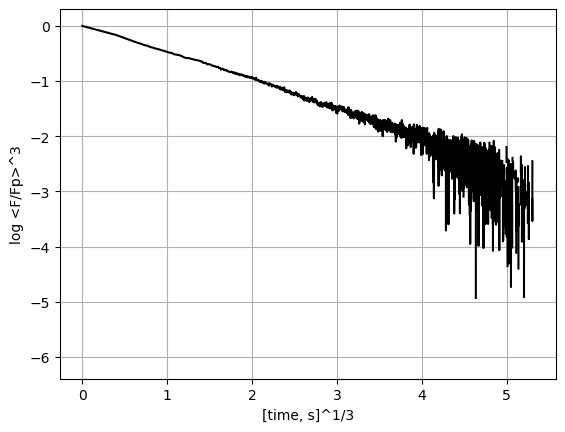

In [13]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_axisbelow(True)
ax.grid(which = 'both')
ax.set_xlabel('[time, s]^1/3')
ax.set_ylabel('log <F/Fp>')
ax.plot(test_times**(1/3), np.log10(averaged_fluxes), color = 'black')

fig = plt.figure()
ax = fig.add_subplot()
ax.set_axisbelow(True)
ax.grid(which = 'both')
ax.set_xlabel('[time, s]^1/3')
ax.set_ylabel('log <F/Fp>^3')
ax.plot(test_times**(1/3), np.log10(averaged_fluxes), color = 'black')


Note: Going at late times, the data start to be very scattered. Maybe we have to make a selection of GRBs to use for the plot?